# Generative Probabilistic Approach with LDA for Document Categorization

In [111]:
import re 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma,gammaln
from scipy.stats import dirichlet

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

%matplotlib inline

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/sxia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Extract $\bm{\alpha}$ and $\bm{\beta}$ from data
## clean up data and tokenize text


Exception ignored in: <function ExcelFile.__del__ at 0x7f1269bed280>
Traceback (most recent call last):
  File "/home/sxia1/.nlp_env/lib/python3.8/site-packages/pandas/io/excel/_base.py", line 1316, in __del__
    try:
KeyboardInterrupt: 


805
641
['Inventive and Curious' 'Consistent and Cautions'
 'Efficient/Organised and Planned' 'Easygoing/Careless and Spontaneous'
 'Outgoing and Energetic' 'Solidatory and Reserved'
 'Friendly and Compassionate' 'Cold and Unkind' 'Sensitive and Nervous'
 'Secure and Confident' 'Not_Well' 'Others']


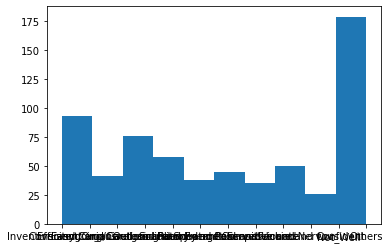

text             innovators are scientists looking for the best...
personalities                                Inventive and Curious
Name: 1, dtype: object
['innovators', 'are', 'scientists', 'looking', 'for', 'the', 'best', 'possible', 'solutions']


/tmp/ipykernel_6539/1568542090.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_words']=list(map(lambda x:len(x),text_tokenized))


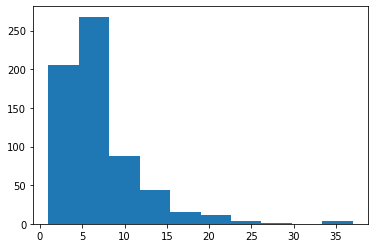

In [379]:
# ### personality data (ignore)
# ## read-in pre-labled tweets
# df_raw = pd.read_excel("data/corpus_new.xlsx",sheet_name="Sheet1",names=["text","personalities"])
# print(len(df_raw))
# #skip non-english text
# df = df_raw[df_raw['text'].apply(lambda x:x.isascii())]
# print(len(df))
# plt.show()
# # tokenize each text
# text_tokenized = list(map(lambda news:nltk.word_tokenize(re.sub(r'[^A_Za-z\s]','',news.lower())), df['text']))
# len(text_tokenized)
# print(df.iloc[0])
# print(text_tokenized[0])
# df['n_words']=list(map(lambda x:len(x),text_tokenized))
# plt.hist(df.n_words)
# plt.show()

### Web of science paper data

46985
['CS ' 'Medical ' 'Civil ' 'ECE ' 'biochemistry ' 'MAE ' 'Psychology  ']


/tmp/ipykernel_333/4099232812.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))


Text(0.5, 1.0, 'abstract word count')

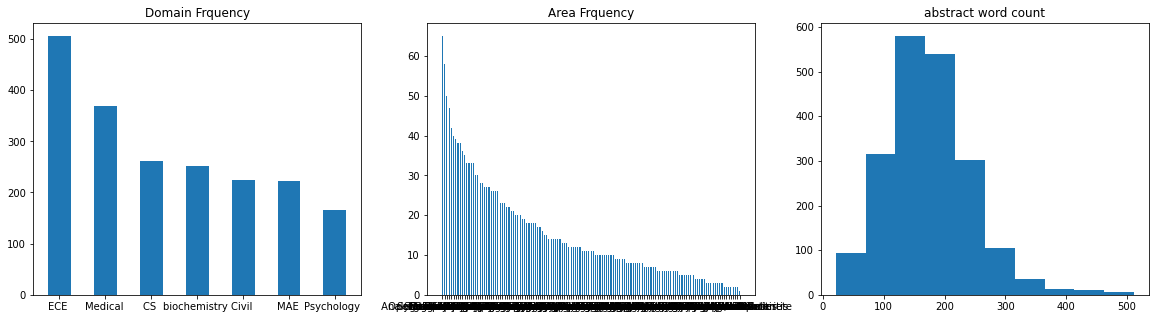

In [4]:
# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(2000) #use first 2000
print(df_paper.Domain.unique())

# remove puncutations and number, then tokenize each text
text_tokenized = list(map(lambda abstract_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',abstract_i.lower())), df_paper['Abstract']))
len(text_tokenized)
df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))

fig,axs = plt.subplots(1,3,figsize=(20,5))
categories = df_paper.Domain.value_counts().index
counts = df_paper.Domain.value_counts().values
axs[0].bar(categories, counts, width=0.5)
axs[0].set_title("Domain Frquency")

categories = df_paper.area.value_counts().index
counts = df_paper.area.value_counts().values
axs[1].bar(categories, counts, width=0.5)
axs[1].set_title("Area Frquency")

axs[2].hist(df_paper.n_words)
axs[2].set_title("abstract word count")

## remove stopwords, make biargam, lemmatize

/tmp/ipykernel_333/1063011778.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))


Text(0.5, 1.0, 'abstract without stop words word count')

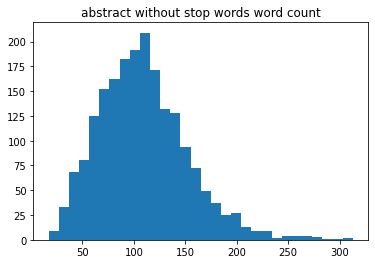

In [5]:
#helper function for lemmatization
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n' #if not belong to any, default is noun, inclunding N

def lemmatize_with_pos(abstract_toekenized):
    abstract_tagged = nltk.pos_tag(abstract_toekenized)
    tags = list(map(lambda token: get_wordnet_pos(token[1]),abstract_tagged))
    abstract_lemmatized = list(map(lemmatizer.lemmatize,abstract_toekenized,tags))
    return abstract_lemmatized


# Creating Bigram: find words frequently occur together
bigram = gensim.models.Phrases(text_tokenized, min_count=20, threshold=50)  
#come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
bigram_freeze = bigram.freeze()
#import nltk lemmatizer
lemmatizer = WordNetLemmatizer()

def prepare_token(text_tokenized_list):
    # remove stopwords and puntuation, 
    text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized_list))

    #apply biagram model
    word_and_bigram_list = list(map(lambda abstract_cleaned: bigram[abstract_cleaned],text_stopwords_removed))

    # lemmatize
    abstract_lemmatized = list(map(lemmatize_with_pos,word_and_bigram_list))
    return abstract_lemmatized

abstract_lemmatized = prepare_token(text_tokenized)
df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))
plt.hist(df_paper.n_words_removed,bins=30)
plt.title("abstract without stop words word count")

['use', 'model', 'system', 'study', 'method', 'propose', 'result', 'control', 'present', 'base', 'show', 'design', 'analysis', 'high', 'cell', 'data', 'also', 'patient', 'effect', 'increase', 'two', 'different', 'time', 'develop', 'process', 'provide', 'new', 'paper', 'include', 'rights_reserved', 'approach', 'compare', 'performance', 'test', 'algorithm', 'level', 'low', 'c_elsevier', 'power', 'measure', 'well', 'structure', 'condition', 'energy', 'find', 'function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'obtain', 'group', 'change']


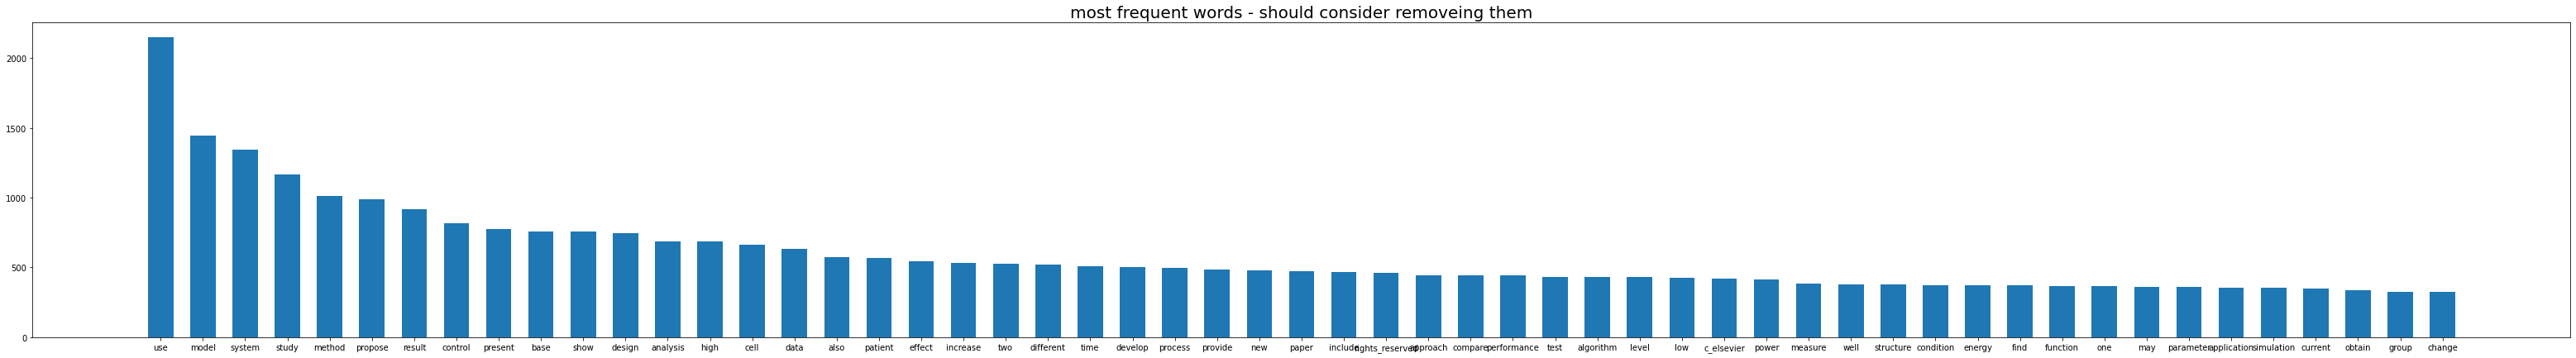

In [6]:
def check_frequent_words(corpus,top_n):
    all_corpus_together=np.concatenate(corpus)
    (word, counts) = np.unique(all_corpus_together, return_counts=True)
    frequencies = np.asarray((word, counts)).T
    count_df = pd.DataFrame(data=frequencies,columns = ['word','freq'])
    count_df.freq = count_df.freq.astype(int)
    count_df.sort_values(by=['freq'],axis=0,ascending=False,ignore_index=True,inplace=True)
    print(list(count_df.head(top_n).word))
    plt.figure(figsize=(top_n,7))
    plt.bar(count_df[:top_n].word,height=count_df[:top_n].freq,width=0.6,align='center')
    plt.title("most frequent words - should consider removeing them",fontsize=20)
    plt.show()
    return count_df

count_df =check_frequent_words(abstract_lemmatized,55)

['well', 'structure', 'condition', 'energy', 'find', 'function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'obtain', 'group', 'change', 'frequency', 'dynamic', 'circuit', 'improve', 'expression']


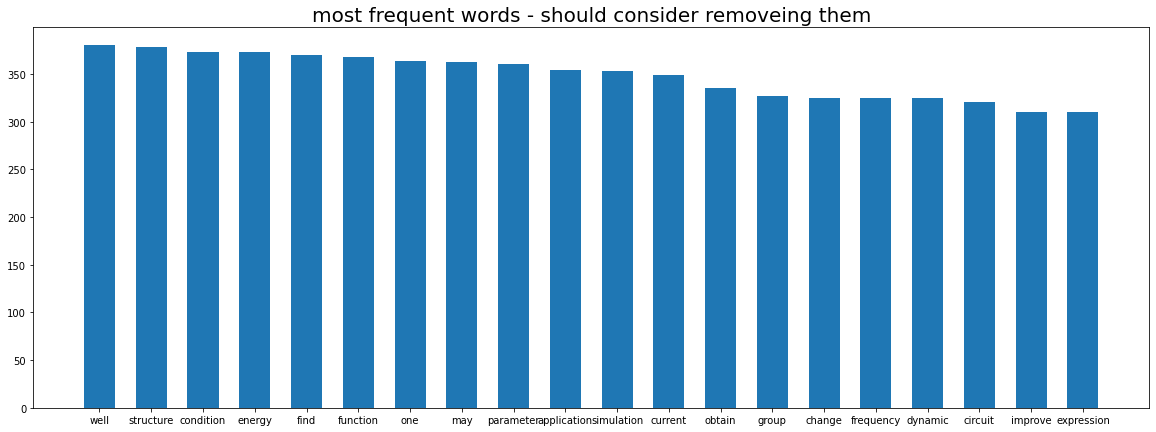

/tmp/ipykernel_333/2061737629.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))


Text(200, 150, 'median length: 91')

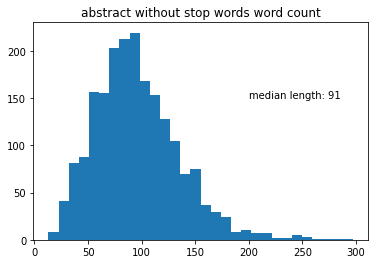

In [7]:
# remove top 50 most frequent words
top_n = list(count_df[:40].word)
abstract_lemmatized_cleaned = list(map(lambda abstract: list(filter(lambda word: word not in top_n, abstract)),abstract_lemmatized))
check_frequent_words(abstract_lemmatized_cleaned,top_n=20)

df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))
median_count = np.median(df_paper.n_words_lemmatize_clean)
plt.hist(df_paper.n_words_lemmatize_clean,bins=30)
plt.title("abstract without stop words word count")
plt.text(200,150,"median length: %d"%median_count,fontsize=10)


In [8]:
np.median(df_paper.n_words_lemmatize_clean)

91.0

## make dictionary and corpus for the inputs to Gensim LDA Model

In [9]:
# define mapping between words to integer ids
word2id = Dictionary(abstract_lemmatized_cleaned)
dictionary = word2id.token2id
vocab_size = len(dictionary)
print("total vocabulary size", vocab_size)
# word2id.token2id gives the dictonary between words and their ids

# define corpus from documents
# documents: a list of lists of strings
# corpus: bag of words: each text = [(word_id, frequency), (word_id, frequency)]
corpus = list(map(word2id.doc2bow,abstract_lemmatized))
print([(word2id[id], freq) for id, freq in corpus[1]])

total vocabulary size 22099
[('p', 1), ('suggest', 1), ('accumulates', 1), ('accumulation', 2), ('across', 1), ('adult', 1), ('age', 2), ('aggregate', 1), ('among', 1), ('ap', 1), ('appear', 1), ('association', 7), ('av', 7), ('become', 1), ('beta', 5), ('betaamyloid', 1), ('brain', 1), ('calculate', 1), ('cluster', 1), ('cognitively', 1), ('correlate', 1), ('correlation', 1), ('correlational', 1), ('cortex', 2), ('cortical', 1), ('cpib', 1), ('demonstrate', 1), ('drive', 1), ('elderly', 1), ('emission', 1), ('examine', 1), ('fav', 1), ('follow', 1), ('fraction', 1), ('frequent', 1), ('frontoparietal', 1), ('global', 1), ('gray', 1), ('however', 1), ('identify', 1), ('image', 2), ('importantly', 1), ('increased', 1), ('increasingly', 1), ('indicate', 1), ('interest', 1), ('kmeans', 1), ('largely', 1), ('less', 1), ('lobe', 3), ('local', 4), ('location', 2), ('magnetic_resonance', 1), ('many', 1), ('matter', 1), ('mean', 1), ('mri', 1), ('multiple', 2), ('nb', 1), ('nonlocal', 3), ('nor

## Use LDA to extract topic distribution and topic-term distribution

In [10]:
# Train the model on the corpus.
lda_model = LdaModel(corpus, num_topics=len(df_paper.Domain.unique()),id2word = word2id)
# Save model to disk.
# temp_file = datapath("model")
# lda.save(temp_file)

# alpha = parameter for Dirichlet Distribution . higer alpha more towards the center, i.e. a mixture of different topic for one document
alpha = lda_model.alpha
print(alpha)
# alpha all parameters are equal => have no prior information to favor one component over any other

#beta = #distribution over word weights in each topic
topic_term_distribution = lda_model.get_topics()
print(np.shape(topic_term_distribution))

print(lda_model.print_topics(num_words=7)) 
#okay, i think i need remove "model", "use", "method", "system", "purpose", "result", "study", "show"



[0.14285715 0.14285715 0.14285715 0.14285715 0.14285715 0.14285715
 0.14285715]
(7, 22099)
[(0, '0.004*"energy" + 0.002*"field" + 0.002*"structure" + 0.002*"dynamic" + 0.002*"obtain" + 0.002*"order" + 0.002*"estimate"'), (1, '0.003*"one" + 0.002*"water" + 0.002*"report" + 0.002*"work" + 0.002*"area" + 0.002*"suggest" + 0.002*"temperature"'), (2, '0.002*"material" + 0.002*"reduce" + 0.002*"treatment" + 0.002*"application" + 0.002*"error" + 0.002*"function" + 0.002*"expression"'), (3, '0.003*"may" + 0.002*"problem" + 0.002*"condition" + 0.002*"current" + 0.002*"structure" + 0.002*"obtain" + 0.002*"treatment"'), (4, '0.003*"condition" + 0.002*"group" + 0.002*"improve" + 0.002*"well" + 0.002*"find" + 0.002*"apply" + 0.002*"may"'), (5, '0.003*"network" + 0.003*"structure" + 0.003*"well" + 0.002*"one" + 0.002*"stress" + 0.002*"energy" + 0.002*"work"'), (6, '0.003*"expression" + 0.003*"circuit" + 0.002*"function" + 0.002*"group" + 0.002*"acid" + 0.002*"current" + 0.002*"simulation"')]


## evalute model perplexity and coherence 
how to interpret these scores?
coherence score is not high

In [11]:
# A lower perplexity score indicates better generalization performance.
perplexity = lda_model.log_perplexity(corpus)
print('Perplexity: ', perplexity )

# get coherence value u_mass
# probability = the number of documents in which the word occurs divided by the total number of documents"
cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary = word2id,coherence='u_mass')
coherence_umass = cm.get_coherence() 
print('UMass Coherence Score: ', coherence_umass)

# Compute Coherence Score using c_v
# CV measure is based on the Pointwise Mutual Information score
coherence_model_lda = CoherenceModel(model=lda_model, texts=abstract_lemmatized_cleaned, dictionary=word2id, coherence="c_v")
coherence_cv = coherence_model_lda.get_coherence()
print('C_v Coherence Score: ', coherence_cv)

Perplexity:  -9.105931362025014
UMass Coherence Score:  -2.4965884075127596
C_v Coherence Score:  0.21317454765300578


In [12]:
n = 43
topic_dist_inferred = lda_model[corpus[n]]
print(df_paper.iloc[n])
topic_dist_inferred

Y1                                                                         3
Y2                                                                         1
Y                                                                         53
Domain                                                                  MAE 
area                                                            Hydraulics  
keywords                    elevated CO2; eucalyptus; genotype; leaf econ...
Abstract                   1. Leaf economics and hydraulic traits strongl...
n_words                                                                  305
n_words_removed                                                          215
n_words_lemmatize_clean                                                  211
Name: 43, dtype: object


[(2, 0.0386446), (3, 0.6459421), (5, 0.31270257)]

## visualize the model
0: CS <br>
1: Civil<br>
2: MAE <br>
3: ECE <br>
4: Psychology <br>
5: Biochemistry <br>
6: Medical <br>

In [13]:
vis_ldamodel = pyLDAvis.gensim_models.prepare(lda_model,corpus,word2id)
vis_ldamodel

/home/sxia1/.nlp_env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/mis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.008058 -0.018190       1        1  19.052843
6      0.033519  0.025399       2        1  14.386162
5     -0.007051 -0.013755       3        1  14.174863
4      0.013576 -0.026717       4        1  13.841144
3     -0.018396  0.028720       5        1  13.011890
2      0.002957  0.006674       6        1  13.009631
0     -0.032663 -0.002131       7        1  12.523467, topic_info=             Term        Freq       Total Category  logprob  loglift
184        energy  335.000000  335.000000  Default  30.0000  30.0000
3049      network  251.000000  251.000000  Default  29.0000  29.0000
9056         tank   47.000000   47.000000  Default  28.0000  28.0000
306    expression  277.000000  277.000000  Default  27.0000  27.0000
23       equation  203.000000  203.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
404       problem   35.703521  260.577687   Topic7  -6.5072   0.0899
431         apply   33.519828  218.858294   Topic7  -6.5703   0.2013
97    demonstrate   33.504166  272.079519   Topic7  -6.5707  -0.0169
353     treatment   33.320268  274.460415   Topic7  -6.5762  -0.0311
44            one   33.453469  330.532742   Topic7  -6.5722  -0.2130

[643 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5944      1  0.162000         abp
5944      7  0.648002         abp
3893      1  0.066858  acceptance
3893      2  0.066858  acceptance
3893      3  0.601719  acceptance
...     ...       ...         ...
686       3  0.130608        year
686       4  0.112798        year
686       5  0.100924        year
686       6  0.154355        year
686       7  0.118735        year

[1972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 5, 4, 3, 1])

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=3):
    """
    Compute c_v coherence for various number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus,num_topics=num_topics,id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=word2id, corpus=corpus, texts=abstract_lemmatized_cleaned, start=5, limit=20, step=1)

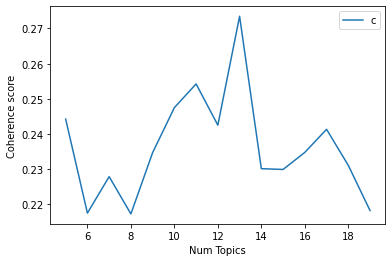

In [15]:
n = range(5, 20, 1)
plt.plot(n, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Using the LDA model, find the topic of any given document
#### Naive Bayes (assume each text only has one topic, will try this and see how bad)
$$
\begin{align}
topic=&argmax_{topic_i} p(words|topic_i)p(topic_i)\\
=&argmax_{topic_i} p(word1|topic_i)p(word2|topic_i)...|p(topic_i)\\
=&argmax_{topic_i} \sum_{word_j} log p(word_j|topic_i)|p(topic_i)
\end{align}
$$

#### Better approach
Since we used LDA, probably better finding topic mixture for each given document. + One research paper can include multiple domains <br>
Get the topic assignment for every word in the new document -> the distribution of topics in that document. <br>
For each document:
we know: W, the text <br>
Unknown: $\phi$, distribution over words for each topic (but we will use what we had for $\bm{\beta}$ from training our LDA model, SparkML Rstudio says orignially use $\bm{\beta}$, bu later paper uses $\phi$ [https://spark.rstudio.com/reference/ml_lda]. Blei extends $\bm{\beta}$ as a random varible drawn from a Dirichlet distirbution for smoothing purpose)<br> 
&emsp;&emsp; &emsp; &emsp;$z$ latent variable, topic of each word <br>
&emsp;&emsp; &emsp; &emsp;$\bm{\theta}$ latent variables, distribution over topics for each document<br>
Goal: find z that maximzes $p(\bm{z}|\bm{w}) -> p(\bm{w}|\bm{z})$

#### MCMC using Gibbs Sampling
Find the conditional probability distribution of a single word’s topic assignment conditioned on the rest of the topic assignments.<br>
$$\begin{align}
p(z_i|\bm{z_{-i}},\bm{\alpha},\bm{\beta},\bm{w}) =& \frac{p(z_i,\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta})}{p(\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta})} \\
 &\propto p(z_i,\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta}) \\
 &\propto P(\bm{z},\bm{w}|\bm{\alpha},\bm{\beta}) 
\end{align} $$

$$
\begin{align}
p(\bm{z},\bm{w}|\bm{\alpha},\bm{\beta}) =& \int p(\bm{z},\bm{w},\bm{\theta}|\bm{\alpha},\bm{\beta})d\bm{\theta}\\
=& \int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) p(\bm{w}|\bm{\beta}_{\bm{z}}) d\bm{\theta} \\
= & p(\bm{w}|\bm{\beta}_{\bm{z}}) \int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) d\bm{\theta}, 
\end{align}$$
where
$$
\begin{align}
p(\bm{w}|\bm{\beta}_{\bm{z}}) = \prod_{j} {\bm{\beta}_{z_j,w_j}}.
\end{align}
$$
Expand the integral term:<br>
The 1st term is: $$ p(\bm{z}|\bm{\theta})= \prod_i \bm{\theta}_{z_i}.$$
The 2nd term is:
$$
\begin{align}
p(\bm{\theta}|\bm{\alpha}) = Dir(\bm{\theta},\bm{\alpha}) = \frac{1}{\Beta(\bm{\alpha})}\prod_{k=0}^{k=N} \theta_k^{\alpha_k-1},
\end{align}
$$
where $N$ is the number of topics, and $\frac{1}{\Beta(\alpha)}$, the normalization constant is given by the multivariate beta function and comupted from gamma function as
$$\Beta(\bm{\alpha}) = \frac{\prod_{k=1}^{k=N}\Gamma(\alpha_k)}{\Gamma(\sum_{k=1}^{k=N}\alpha_k)}.$$

Plug in these two terms into the integral term:
$$
\begin{align}
\int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) d\bm{\theta} =& \int \prod_i \bm{\theta}_{z_i} \frac{1}{\Beta(\bm{\alpha})}\prod_{k=0}^{k=N} \theta_k^{\alpha_k-1} d\bm{\theta}\\
= & \frac{1}{\Beta(\bm{\alpha})} \int \prod_i \bm{\theta}_{z_i} \prod_{k=0}^{k=N} \theta_k^{\alpha_k-1} d\bm{\theta}\\
= & \frac{1}{\Beta(\bm{\alpha})} \int \prod_k \theta_k ^{n_k+\alpha_k-1} d\bm{\theta} \hskip{0.5 in} (n_k =\textrm{ the number of times }z_i=k)\textrm{, and define }\bm{n} = [n_1,n_2,...,n_k] \\
= & \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \int \frac{1}{\Beta(\bm{\alpha}+\bm{n})} \prod_k \theta_k ^{n_k+\alpha_k-1} d\bm{\theta} \\
=& \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \int Dir(\bm{\theta},\bm{\alpha}+\bm{n}) d\bm{\theta} \\
=& \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})}
\end{align}
$$
Thus 
$$ 
p(\bm{w},\bm{z}|\bm{\alpha},\bm{\beta})=\frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \prod_{j} {\bm{\beta}_{z_j,w_j}}.
$$
Conditional distribution for how to draw topic $z_i$ for word $w_i$:
$$\begin{align}
p(z_i|\bm{z_{-i}},\bm{w},\bm{\alpha},\bm{\beta}) =& \frac{p(\bm{z},\bm{w}|,\bm{\alpha},\bm{\beta})}{p(\bm{z_{-i}},\bm{w}|,\bm{\alpha},\bm{\beta})}\\
\propto &  \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \prod_{j} {\bm{\beta}_{z_j,w_j}} / \frac{\Beta(\bm{\alpha}+\bm{n_{-i}})}{\Beta(\bm{\alpha})} \prod_{j \neq i} {\bm{\beta}_{z_j,w_j}} \\
\propto &  \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha}+\bm{n_{-i}})}\frac{\prod_{j} {\bm{\beta}_{z_j,w_j}} }{\prod_{j \neq i} {\bm{\beta}_{z_j,w_j}} }\\
\propto & \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha}+\bm{n_{-i}})}\bm{\beta}_{z_i,w_i}\\
\propto & \frac{\prod_{k=1}^{k=N}\Gamma((\bm{\alpha}+\bm{n})_k)}{\Gamma(\sum_{k=1}^{k=N}(\bm{\alpha}+\bm{n})_k)} \frac{\Gamma(\sum_{k=1}^{k=N}(\bm{\alpha}+\bm{n_{-i}})_k)}{\prod_{k=1}^{k=N}\Gamma((\bm{\alpha}+\bm{n_{-i}})_k)} \bm{\beta}_{z_i,w_i}
\end{align} $$


The sampling process is:
* Initailize $\bm{z}$
* while not max_iteration/not converged:
    * for each word $w_i$ in $\bm{w}$:
        1. compute  conditional_p = $p(z_i|\bm{z_{-i}},\bm{w},\bm{\alpha},\bm{\beta})$ ( probabily of $z_i=k$ for each topic $k$ from $N$ total topics)
        2. draw $z_i$ from Multinomial(conditional_p)
        3. update $z_i$, save this 
    * estimate $\bm{\theta}$:$$\theta_k = \frac{n_k+\alpha_k}{\sum_{k} n_k+\alpha_k}$$
    * compute $p(\bm{\theta},\bm{w},\bm{z}|\alpha,\beta)$:
            $$p(\bm{\theta},\bm{w},\bm{z}|\alpha,\beta) = \log p(\bm{\theta}|\bm{\alpha})+ \sum_{i=0}^{len(\bm{w})}\log p(w_i|z_i,\bm{\beta})  +\log p(z_i|\bm{\theta}) = \log p(\bm{\theta}|\bm{\alpha}) +\sum_{i=0}^{len(\bm{w})} \log \beta_{zi,wi} +\log p(z_i|\bm{\theta})            $$



In [16]:
# step1:  given an abstract/text, tokenize, find biargram, remove popular words
def prepare_text(text_list):
    tokenized = list(map(lambda text_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',text_i.lower())),text_list))
    text_uncategorized = prepare_token(tokenized)
    # map corpus to a bag of words, lda doc2idx ignore unknown words
    corpus_uncategorized  = list(map(lambda document: word2id.doc2bow(document, return_missing=False),text_uncategorized))
    corpus_uncategorized  = list(map(lambda document: np.array(word2id.doc2idx(document)),text_uncategorized))
    corpus_uncategorized = list(map(lambda document: document[document>=0],corpus_uncategorized))
    return corpus_uncategorized
text_list = df_paper.Abstract[50:52]
corpus_uncategorized = prepare_text(text_list)

In [153]:
class GibbsSampler_Predict:
    def __init__(self, n_topics,alpha=0.2,beta=0.1):
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta
        self.theta = 0
        self.z_vec = 0
        self.w_vec = None
        self.text_length = 0
        self.maxiter = 5
        self.log_likelihood_list = []


    def initialize(self,words):
        self.w_vec = words
        self.text_length = len(words)
        # initialize z_vec closer to the posterior distribution based on alpha parameter
        self.theta = np.random.dirichlet(self.alpha)
        self.z_vec = np.random.choice(range(self.n_topics),len(self.w_vec),p=self.theta)
    
    def _conditional_prob(self,i):
        # conditional probablity distribution of zi=k for word w_i given alpha and beta
        z_matrix_zi_all_k = np.tile(self.z_vec,(self.n_topics,1))
        z_matrix_zi_all_k[:,i] = np.arange(0,self.n_topics,1)
        n_matrix_all_k = np.array(list(map(lambda j: np.sum(z_matrix_zi_all_k==j,axis=1),range(self.n_topics)))).T

        z_matrix_min_i = np.delete(z_matrix_zi_all_k,i,1)
        n_matrix_min_i = np.array(list(map(lambda j: np.sum(z_matrix_min_i==j,axis=1),range(self.n_topics)))).T

        top = np.prod(gamma(self.alpha+n_matrix_all_k),axis=1)/gamma(np.sum(self.alpha+n_matrix_all_k,axis=1))
        bottom= np.prod(gamma(self.alpha+n_matrix_min_i),axis=1)/gamma(np.sum(self.alpha+n_matrix_min_i,axis=1))
        p_wi_zi = self.beta[:,self.w_vec[i]]

        prob = top/bottom*p_wi_zi
        prob_normalized = prob/np.sum(prob)

        return prob_normalized
    
    def _estimate_theta(self):
        n_vec = np.array(list(map(lambda j: np.sum(self.z_vec==j),range(self.n_topics))))
        theta = (n_vec+alpha)/np.sum(n_vec+alpha)
        return theta

    def _logP_theta_z_w(self,theta):
        logP_w_z_theta = np.sum(list(map(lambda i: np.log(theta[self.z_vec[i]])+np.log(beta[(self.z_vec[i],self.w_vec[i])]),range(self.text_length))))
        logP_theta_alpha = dirichlet.logpdf(theta, self.alpha)
        logP = logP_theta_alpha+logP_w_z_theta
        return logP


    def sample(self,maxiter=5):
        self.maxiter = maxiter
        iter = 0
        #got to final estimated z_vec
        while iter < maxiter:
                iter += 1
                for i in range(self.text_length):
                    conditional_p = self._conditional_prob(i)
                    z_i_new = np.argmax(np.random.multinomial(1,conditional_p))# sample topic for i_th word in W from conditional probability
                    self.z_vec[i] = z_i_new        
                theta = self._estimate_theta()
                log_likelihood = self._logP_theta_z_w(theta)
                self.log_likelihood_list.append(log_likelihood)
        self.theta = theta
    
    def plot(self):
        plt.plot(np.arange(0,self.maxiter,1),self.log_likelihood_list)
        plt.xlabel("iteration")
        plt.ylabel("log likliehood")
        plt.show()



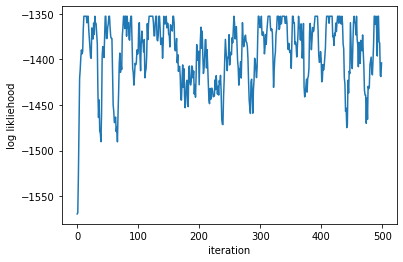

[8.87311486e-04 6.29991127e-02 8.87311486e-04 1.33096717e-02
 9.20141970e-01 8.87311486e-04 8.87311486e-04]
most salient topic: 4
Gensim result: [(0, 0.43061423), (5, 0.563594)]


In [166]:
GBS_sampler = GibbsSampler_Predict(n_topics=7,alpha=alpha,beta=beta)
GBS_sampler.initialize(corpus_d)
GBS_sampler.sample(maxiter=500)
GBS_sampler.plot()

topic_weight = GBS_sampler.theta
dominant_topic = np.argmax(topic_weight)
print(topic_weight)
print("most salient topic:",dominant_topic)
# gensim implementation
topic_dist_inferred = lda_model[corpus[0]]
print("Gensim result:", topic_dist_inferred)

In [120]:
#### ignore
# def conditional_prob(i):
#     # conditional probablity distribution of zi=k for word w_i given alpha and beta
#     z_matrix_zi_all_k = np.tile(z_vec,(n_topics,1))
#     z_matrix_zi_all_k[:,i] = np.arange(0,n_topics,1)
#     n_matrix_all_k = np.array(list(map(lambda j: np.sum(z_matrix_zi_all_k==j,axis=1),range(n_topics)))).T

#     z_matrix_min_i = np.delete(z_matrix_zi_all_k,i,1)
#     n_matrix_min_i = np.array(list(map(lambda j: np.sum(z_matrix_min_i==j,axis=1),range(n_topics)))).T

#     top = np.prod(gamma(alpha+n_matrix_all_k),axis=1)/gamma(np.sum(alpha+n_matrix_all_k,axis=1))
#     bottom= np.prod(gamma(alpha+n_matrix_min_i),axis=1)/gamma(np.sum(alpha+n_matrix_min_i,axis=1))
#     p_wi_zi = beta[:,w_vec[i]] #?? bag of words should I multiply by how many times wi in the text??

#     prob = top/bottom*p_wi_zi
#     prob_normalized = prob/np.sum(prob)

#     return prob_normalized

# def estimate_theta(z_vec):
#     n_vec = np.array(list(map(lambda j: np.sum(z_vec==j),range(n_topics))))
#     theta = (n_vec+alpha)/np.sum(n_vec+alpha)
#     return theta

# def logP_theta_z_w(z_vec,theta):
#     logP_w_z_theta = np.sum(list(map(lambda i: np.log(theta[z_vec[i]])+np.log(beta[(z_vec[i],w_vec[i])]),range(len(z_vec)))))
#     logP_theta_alpha = dirichlet.logpdf(theta, alpha)
#     logP = logP_theta_alpha+logP_w_z_theta
#     return logP


# corpus_d = corpus_uncategorized[0]
# # initialize \bm{\theta} and z
# w_vec = corpus_d
# n_topics=7
# alpha = lda_model.alpha
# beta = lda_model.get_topics()
# text_length = len(w_vec)
# theta = np.random.dirichlet(alpha)
# z_vec = np.random.choice(range(7),text_length,p=theta)
# print(z_vec)

# iter = 0
# maxiter = 600
# log_likelihoods = []
# while iter < maxiter:
#         iter += 1
#         for i in range(len(w_vec)):
#             conditional_p = conditional_prob(i)
#             z_i_new = np.argmax(np.random.multinomial(1,conditional_p))# sample topic for i_th word in W from conditional probability
#             z_vec[i] = z_i_new        
#         theta = estimate_theta(z_vec)
#         log_likelihood = logP_theta_z_w(z_vec,theta)
#         log_likelihoods.append(log_likelihood)
        
            
# print(z_vec)

# print(theta)
# print(np.argmax(theta))

# plt.plot(np.arange(0,maxiter,1),log_likelihoods)
# plt.xlabel("iteration")
# plt.ylabel("log likliehood")
# plt.show()

# use $\alpha$ and $\bm{\beta}$ to generate synthetic data

In [161]:

topic_dictionary = {0: "CS", 1: "Civil", 2: "MAE", 3: "ECE",4: "Psychology", 5: "Biochemistry", 6: "Medical"}

# Possion distribution: draw sample length, lambda = median from the data
# alpha: topic mixture of each synethic text
# beta: topic-term distribution
def lda_gen(vocabulary,beta,alpha,possion_lambda):
    xi = np.random.poisson(possion_lambda) #length = sample from poisson dist
    v = np.shape(beta)[0]
    topic_proportion = np.random.dirichlet(alpha) # generate topic proportion based of a text dist
    dominant_domain = topic_dictionary[np.argmax(topic_proportion)]
    topic_list = np.random.choice(range(v),xi,p=topic_proportion) #sample from topic proportion dist, 

    #pick a word for each topic in each document
    # frequency of the topics = topics mixture in each document
    word_bag = []
    for topic_index in topic_list:
        word = np.random.choice(vocabulary,p=beta[topic_index])
        word_bag.append(word)
    return (dominant_domain,word_bag)



In [171]:
vocabulary = list(dictionary.keys())
alpha = lda_model.alpha()
beta = lda_model.get_topics()
possion_lambda = median_count

synthetic_data_size = 1000
synthetic_data = [ lda_gen(vocabulary,beta,alpha,possion_lambda) for _ in range(synthetic_data_size)]

synthetic_df = pd.DataFrame(synthetic_data,columns=['Domain','Abstract'])

synthetic_df.Abstract = synthetic_df.Abstract.map(lambda a: " ".join(a))
#synthetic_df.to_csv("mockdata.csv",index=False)


## Categorize the synthetic data with my probabilistic classifier